In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aptos2019/valid.csv
/kaggle/input/aptos2019/test.csv
/kaggle/input/aptos2019/train_1.csv
/kaggle/input/aptos2019/val_images/val_images/17f6c7072f61.png
/kaggle/input/aptos2019/val_images/val_images/0243404e8a00.png
/kaggle/input/aptos2019/val_images/val_images/0083ee8054ee.png
/kaggle/input/aptos2019/val_images/val_images/0ac436400db4.png
/kaggle/input/aptos2019/val_images/val_images/0d0a21fd354f.png
/kaggle/input/aptos2019/val_images/val_images/02da652c74b8.png
/kaggle/input/aptos2019/val_images/val_images/15e96e848b46.png
/kaggle/input/aptos2019/val_images/val_images/059bc89df7f4.png
/kaggle/input/aptos2019/val_images/val_images/04d029cfb612.png
/kaggle/input/aptos2019/val_images/val_images/08752092140d.png
/kaggle/input/aptos2019/val_images/val_images/0ef4c61dc056.png
/kaggle/input/aptos2019/val_images/val_images/1a7e3356b39c.png
/kaggle/input/aptos2019/val_images/val_images/06be1092a062.png
/kaggle/input/aptos2019/val_images/val_images/03a7f4a5786f.png
/kaggle/input/a

--- Starting Path Verification ---
Successfully loaded CSV. Testing with image ID: 1ae8c165fd53 (Diagnosis: 2)

Attempting to load original image from:
/kaggle/input/aptos2019/train_images/train_images/1ae8c165fd53.png
Attempting to load segmented mask from:
/kaggle/input/segmentaion-dataset/segmented_outputs_train_1/segmented_outputs_train_1/1ae8c165fd53.png
✅ Original image loaded successfully.
✅ Segmented mask loaded successfully.

Displaying images for visual confirmation...


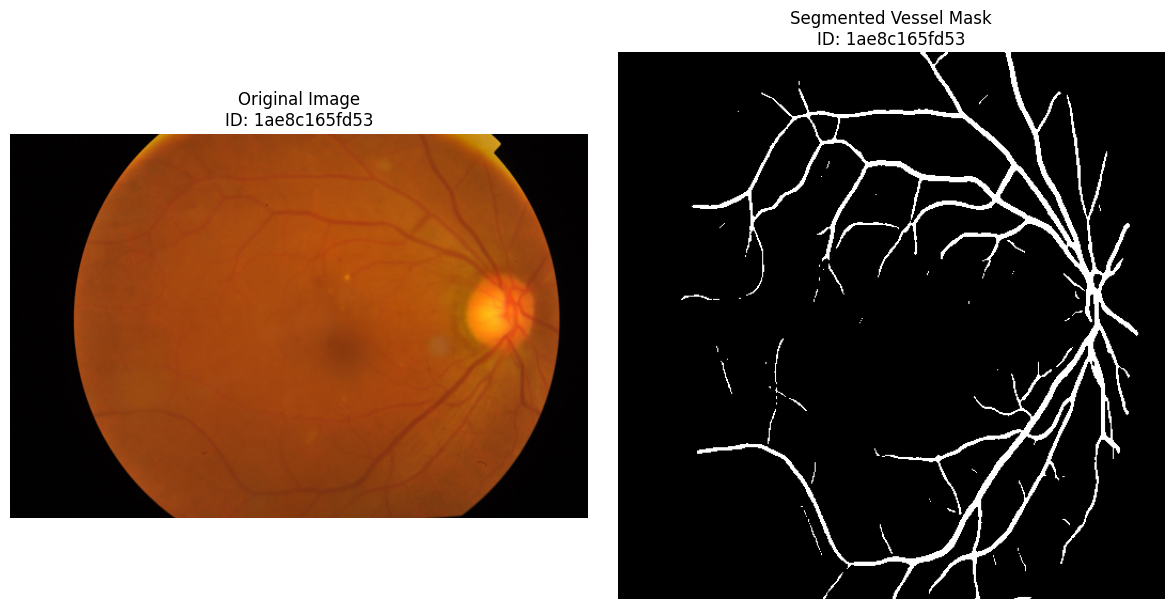

In [2]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

# =============================================================================
# CONFIGURATION - Paths to verify
# =============================================================================
class Cfg:
    # --- DATA PATHS ---
    # Original Image Paths
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    
    # --- PATHS TO YOUR NEW SEGMENTED MASKS (from your screenshot) ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_TRAIN_DIR = os.path.join(SEG_BASE_PATH, "segmented_outputs_train_1/segmented_outputs_train_1/")

# =============================================================================
# VERIFICATION SCRIPT
# =============================================================================

print("--- Starting Path Verification ---")

# 1. Load the CSV and get the first image ID
try:
    train_df = pd.read_csv(Cfg.TRAIN_CSV)
    first_row = train_df.iloc[0]
    image_id = first_row['id_code']
    image_label = first_row['diagnosis']
    print(f"Successfully loaded CSV. Testing with image ID: {image_id} (Diagnosis: {image_label})")
except Exception as e:
    print(f"Error loading CSV file: {e}")
    image_id = None

if image_id:
    # 2. Construct the full paths
    original_image_path = os.path.join(Cfg.TRAIN_DIR, image_id + '.png')
    segmented_mask_path = os.path.join(Cfg.SEG_TRAIN_DIR, image_id + '.png')

    print(f"\nAttempting to load original image from:\n{original_image_path}")
    print(f"Attempting to load segmented mask from:\n{segmented_mask_path}")

    # 3. Load the images
    try:
        original_img = cv2.imread(original_image_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        if original_img is None: raise FileNotFoundError
        print("✅ Original image loaded successfully.")
    except Exception as e:
        original_img = None
        print(f"❌ ERROR: Failed to load original image. Please check the TRAIN_DIR path. Details: {e}")

    try:
        segmented_mask = cv2.imread(segmented_mask_path, cv2.IMREAD_GRAYSCALE)
        if segmented_mask is None: raise FileNotFoundError
        print("✅ Segmented mask loaded successfully.")
    except Exception as e:
        segmented_mask = None
        print(f"❌ ERROR: Failed to load segmented mask. Please check the SEG_TRAIN_DIR path. Details: {e}")
        
    # 4. Display the images side-by-side if both were loaded
    if original_img is not None and segmented_mask is not None:
        print("\nDisplaying images for visual confirmation...")
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        axes[0].imshow(original_img)
        axes[0].set_title(f"Original Image\nID: {image_id}")
        axes[0].axis('off')
        
        axes[1].imshow(segmented_mask, cmap='gray')
        axes[1].set_title(f"Segmented Vessel Mask\nID: {image_id}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("\nCould not display images because one or both files failed to load.")


# Efficent net B3

In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION FOR 4-CHANNEL (IMAGE + VESSEL MASK) INPUT
# =============================================================================
class CFG:
    # --- MODEL & IMAGE SIZE (Same as your baseline EffNet-B3) ---
    MODEL_NAME = 'efficientnet_b3'
    IMG_SIZE = 384
    BATCH_SIZE = 8

    # --- DATA PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
    
    # --- PATHS TO YOUR NEW SEGMENTED MASKS ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_TRAIN_DIR = os.path.join(SEG_BASE_PATH, "segmented_outputs_train_1/segmented_outputs_train_1/")
    SEG_VAL_DIR   = os.path.join(SEG_BASE_PATH, "segmented_outputs_val/segmented_outputs_val/")

    # --- TRAINING PIPELINE (Identical to your successful run for fair comparison) ---
    S1_EPOCHS = 15; S1_LR = 1e-4; S1_USE_MIXUP = True
    S2_EPOCHS = 15; S2_LR = 3e-5; S2_USE_MIXUP = False
    
    # --- GENERAL & SAVING ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05
    # New save paths for this experiment
    SAVE_PATH_S1 = "best_model_effnet_b3_seg_stage1.pth"
    SAVE_PATH_FINAL = "best_model_effnet_b3_seg_final.pth"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = True
seed_everything(CFG.SEED)

# =============================================================================
# PREPROCESSING & AUGMENTATIONS (CORRECTED LOGIC)
# =============================================================================
def preprocess_ben_graham(image, output_size):
    # This function only preprocesses the 3-channel image
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: 
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
        else:
            _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                image = image[y:y+h, x:x+w]
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    except Exception: 
        image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    
    return cv2.merge((b, g, r))

def get_transforms(is_train=True):
    # This pipeline now only contains augmentations. Preprocessing happens before.
    if is_train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        ])
    else:
        # No augmentations for validation/test
        return None

# =============================================================================
# UPGRADED DATASET (CORRECTED LOGIC)
# =============================================================================
class Dataset4Channel(Dataset):
    def __init__(self, df, img_dir, seg_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        # The final normalization/tensor conversion is always applied
        self.post_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]),
            ToTensorV2()
        ])

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        seg_path = os.path.join(self.seg_dir, row['id_code'] + '.png')
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        
        # Step 1: Apply preprocessing to the 3-channel RGB image first
        img = preprocess_ben_graham(img, CFG.IMG_SIZE)
        
        # Step 2: Resize the mask to the exact same size to ensure alignment
        mask = cv2.resize(mask, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        
        # Step 3: Apply geometric and color augmentations to the ALIGNED pair
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            
        # Step 4: Add the mask as the 4th channel
        img_4_channel = np.dstack((img, mask))
        
        # Step 5: Apply final normalization and convert to tensor
        img_4_channel = self.post_transform(image=img_4_channel)['image']
            
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img_4_channel, label

# =============================================================================
# UPGRADED MODEL TO ACCEPT 4 CHANNELS (Unchanged, was already correct)
# =============================================================================
class EfficientNet4ChannelOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        
        original_conv = self.backbone.conv_stem
        original_weights = original_conv.weight.clone()

        new_conv = nn.Conv2d(4, original_conv.out_channels, 
                             kernel_size=original_conv.kernel_size, stride=original_conv.stride, 
                             padding=original_conv.padding, bias=(original_conv.bias is not None))
        with torch.no_grad():
            new_conv.weight[:, :3] = original_weights
            new_conv.weight[:, 3] = original_weights.mean(dim=1)
        self.backbone.conv_stem = new_conv
        
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))

    def forward(self, x): 
        return self.classifier(self.backbone(x))

# --- Loss functions, training loops, and other utilities are unchanged ---
class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes, self.gamma, self.class_weights, self.label_smoothing = num_classes, gamma, class_weights, label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0: ordinal_targets[i, :t] = 1.0
        if self.label_smoothing > 0.0: ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        bce = self.bce(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights
        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes, self.eps = num_classes, eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes): W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)
    def forward(self, outputs, targets):
        device = outputs.device; B = outputs.size(0); probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1): class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        hist_true = one_hot.sum(dim=0); hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        W = self.W.to(device); obs = torch.sum(W * conf_mat); exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]; index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def ordinal_to_class(outputs): 
    return torch.sum(torch.sigmoid(outputs) > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    return accuracy_score(targets_np, preds), cohen_kappa_score(targets_np, preds, weights='quadratic')

def clear_memory(): 
    gc.collect()
    torch.cuda.empty_cache()

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train(); running_loss = 0.0; all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item(); all_out.append(outputs.detach()); all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME} (4-Channel), Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV)
    val_df = pd.read_csv(CFG.VAL_CSV)
    
    train_tf = get_transforms(is_train=True)
    val_tf = get_transforms(is_train=False)

    train_ds = Dataset4Channel(train_df, CFG.TRAIN_DIR, CFG.SEG_TRAIN_DIR, transform=train_tf)
    val_ds   = Dataset4Channel(val_df, CFG.VAL_DIR, CFG.SEG_VAL_DIR, transform=val_tf)

    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    
    model = EfficientNet4ChannelOrdinal(CFG.MODEL_NAME).to(CFG.DEVICE)
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    def hybrid_loss(outputs, targets): 
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1 ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1 (4-Channel)\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss:{train_loss:.4f} Acc:{train_acc:.4f} QWK:{train_qwk:.4f}")
        print(f"Valid -> Loss:{val_loss:.4f} Acc:{val_acc:.4f} QWK:{val_qwk:.4f}")
        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_S1)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: 
                print("Early stopping in Stage 1.")
                break
    
    # --- STAGE 2 ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2 (4-Channel)\n" + "="*50)
    if os.path.exists(CFG.SAVE_PATH_S1):
        model.load_state_dict(torch.load(CFG.SAVE_PATH_S1))
    else:
        print("No Stage 1 model was saved. Continuing with the current model.")

    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss:{train_loss:.4f} Acc:{train_acc:.4f} QWK:{train_qwk:.4f}")
        print(f"Valid -> Loss:{val_loss:.4f} Acc:{val_acc:.4f} QWK:{val_qwk:.4f}")
        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_FINAL)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: 
                print("Early stopping in Stage 2.")
                break

    print(f"\nTraining Finished!\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()



Device: cuda, Model: efficientnet_b3 (4-Channel), Image Size: 384


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


     STARTING STAGE 1 (4-Channel)

Epoch 1/15


/tmp/ipykernel_36/1760248416.py:295: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.4493 Acc:0.2427 QWK:0.1624
Valid -> Loss:0.1698 Acc:0.1667 QWK:0.6311
Val QWK improved from -1.0000 to 0.6311. Saving model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.3518 Acc:0.3205 QWK:0.3084
Valid -> Loss:0.1597 Acc:0.1995 QWK:0.5926

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.3046 Acc:0.3570 QWK:0.3340
Valid -> Loss:0.1493 Acc:0.2186 QWK:0.5932

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2886 Acc:0.3795 QWK:0.3746
Valid -> Loss:0.1664 Acc:0.2022 QWK:0.6267

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2622 Acc:0.4085 QWK:0.3973
Valid -> Loss:0.1545 Acc:0.2787 QWK:0.6644
Val QWK improved from 0.6311 to 0.6644. Saving model...

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2483 Acc:0.4020 QWK:0.4069
Valid -> Loss:0.1458 Acc:0.2923 QWK:0.6758
Val QWK improved from 0.6644 to 0.6758. Saving model...

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2196 Acc:0.3990 QWK:0.4121
Valid -> Loss:0.1595 Acc:0.2568 QWK:0.6517

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2048 Acc:0.4232 QWK:0.4365
Valid -> Loss:0.1502 Acc:0.3197 QWK:0.6806
Val QWK improved from 0.6758 to 0.6806. Saving model...

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2062 Acc:0.4010 QWK:0.4233
Valid -> Loss:0.1611 Acc:0.3033 QWK:0.6966
Val QWK improved from 0.6806 to 0.6966. Saving model...

Epoch 10/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1950 Acc:0.4382 QWK:0.4733
Valid -> Loss:0.1529 Acc:0.3115 QWK:0.6905

Epoch 11/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2039 Acc:0.4177 QWK:0.4403
Valid -> Loss:0.1450 Acc:0.3852 QWK:0.7519
Val QWK improved from 0.6966 to 0.7519. Saving model...

Epoch 12/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.2050 Acc:0.4512 QWK:0.4698
Valid -> Loss:0.1462 Acc:0.4153 QWK:0.7543
Val QWK improved from 0.7519 to 0.7543. Saving model...

Epoch 13/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1971 Acc:0.4413 QWK:0.4770
Valid -> Loss:0.1434 Acc:0.4399 QWK:0.7689
Val QWK improved from 0.7543 to 0.7689. Saving model...

Epoch 14/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1905 Acc:0.4314 QWK:0.4472
Valid -> Loss:0.1457 Acc:0.3907 QWK:0.7453

Epoch 15/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1984 Acc:0.4543 QWK:0.4836
Valid -> Loss:0.1489 Acc:0.4098 QWK:0.7661

     STARTING STAGE 2 (4-Channel)

Epoch 1/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1896 Acc:0.6645 QWK:0.8861
Valid -> Loss:0.2386 Acc:0.6913 QWK:0.8659
Val QWK improved from 0.7689 to 0.8659. Saving final model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1140 Acc:0.8222 QWK:0.9482
Valid -> Loss:0.1923 Acc:0.7404 QWK:0.8832
Val QWK improved from 0.8659 to 0.8832. Saving final model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.1044 Acc:0.8375 QWK:0.9501
Valid -> Loss:0.1794 Acc:0.7650 QWK:0.8928
Val QWK improved from 0.8832 to 0.8928. Saving final model...

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0919 Acc:0.8672 QWK:0.9603
Valid -> Loss:0.1765 Acc:0.7678 QWK:0.8972
Val QWK improved from 0.8928 to 0.8972. Saving final model...

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0835 Acc:0.8816 QWK:0.9643
Valid -> Loss:0.1885 Acc:0.7787 QWK:0.8912

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0830 Acc:0.8795 QWK:0.9640
Valid -> Loss:0.1823 Acc:0.7787 QWK:0.8902

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0799 Acc:0.8959 QWK:0.9696
Valid -> Loss:0.1864 Acc:0.7869 QWK:0.8923

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0756 Acc:0.9055 QWK:0.9703
Valid -> Loss:0.1791 Acc:0.7978 QWK:0.9040
Val QWK improved from 0.8972 to 0.9040. Saving final model...

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0712 Acc:0.9072 QWK:0.9716
Valid -> Loss:0.1757 Acc:0.7869 QWK:0.9005

Epoch 10/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0671 Acc:0.9140 QWK:0.9747
Valid -> Loss:0.1845 Acc:0.7869 QWK:0.8941

Epoch 11/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0626 Acc:0.9147 QWK:0.9738
Valid -> Loss:0.1793 Acc:0.7978 QWK:0.9028

Epoch 12/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0667 Acc:0.9092 QWK:0.9737
Valid -> Loss:0.1827 Acc:0.8005 QWK:0.8982

Epoch 13/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:261: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train -> Loss:0.0645 Acc:0.9184 QWK:0.9757
Valid -> Loss:0.1869 Acc:0.8005 QWK:0.8971
Early stopping in Stage 2.

Training Finished!
Final Best QWK: 0.9040


In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION FOR 4-CHANNEL (IMAGE + VESSEL MASK) INPUT
# =============================================================================
class CFG:
    # --- MODEL & IMAGE SIZE (Same as your baseline EffNet-B3) ---
    MODEL_NAME = 'efficientnet_b3'
    IMG_SIZE = 384
    BATCH_SIZE = 8

    # --- DATA PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
    
    # --- PATHS TO YOUR NEW SEGMENTED MASKS ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_TRAIN_DIR = os.path.join(SEG_BASE_PATH, "segmented_outputs_train_1/segmented_outputs_train_1/")
    SEG_VAL_DIR   = os.path.join(SEG_BASE_PATH, "segmented_outputs_val/segmented_outputs_val/")

    # --- TRAINING PIPELINE (Identical to your successful run for fair comparison) ---
    S1_EPOCHS = 15; S1_LR = 1e-4; S1_USE_MIXUP = True
    S2_EPOCHS = 15; S2_LR = 3e-5; S2_USE_MIXUP = False
    
    # --- GENERAL & SAVING ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05
    # New save paths for this experiment
    SAVE_PATH_S1 = "best_model_effnet_b3_seg_stage1.pth"
    SAVE_PATH_FINAL = "best_model_effnet_b3_seg_final.pth"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = True
seed_everything(CFG.SEED)

# =============================================================================
# PREPROCESSING & AUGMENTATIONS (CORRECTED LOGIC)
# =============================================================================
def preprocess_ben_graham(image, output_size):
    # This function only preprocesses the 3-channel image
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: 
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
        else:
            _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)
                image = image[y:y+h, x:x+w]
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    except Exception: 
        image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g = clahe.apply(g)
    
    return cv2.merge((b, g, r))

def get_transforms(is_train=True):
    # This pipeline now only contains augmentations. Preprocessing happens before.
    if is_train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        ])
    else:
        # No augmentations for validation/test
        return None

# =============================================================================
# UPGRADED DATASET (CORRECTED LOGIC)
# =============================================================================
class Dataset4Channel(Dataset):
    def __init__(self, df, img_dir, seg_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        # The final normalization/tensor conversion is always applied
        self.post_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]),
            ToTensorV2()
        ])

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        seg_path = os.path.join(self.seg_dir, row['id_code'] + '.png')
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        
        # Step 1: Apply preprocessing to the 3-channel RGB image first
        img = preprocess_ben_graham(img, CFG.IMG_SIZE)
        
        # Step 2: Resize the mask to the exact same size to ensure alignment
        mask = cv2.resize(mask, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        
        # Step 3: Apply geometric and color augmentations to the ALIGNED pair
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            
        # Step 4: Add the mask as the 4th channel
        img_4_channel = np.dstack((img, mask))
        
        # Step 5: Apply final normalization and convert to tensor
        img_4_channel = self.post_transform(image=img_4_channel)['image']
            
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img_4_channel, label

# =============================================================================
# UPGRADED MODEL TO ACCEPT 4 CHANNELS (Unchanged, was already correct)
# =============================================================================
class EfficientNet4ChannelOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        
        original_conv = self.backbone.conv_stem
        original_weights = original_conv.weight.clone()

        new_conv = nn.Conv2d(4, original_conv.out_channels, 
                             kernel_size=original_conv.kernel_size, stride=original_conv.stride, 
                             padding=original_conv.padding, bias=(original_conv.bias is not None))
        with torch.no_grad():
            new_conv.weight[:, :3] = original_weights
            new_conv.weight[:, 3] = original_weights.mean(dim=1)
        self.backbone.conv_stem = new_conv
        
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))

    def forward(self, x): 
        return self.classifier(self.backbone(x))

# --- Loss functions, training loops, and other utilities are unchanged ---
class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__()
        self.num_classes, self.gamma, self.class_weights, self.label_smoothing = num_classes, gamma, class_weights, label_smoothing
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0: ordinal_targets[i, :t] = 1.0
        if self.label_smoothing > 0.0: ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        bce = self.bce(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1])
            bce = bce * weights
        pt = torch.exp(-bce)
        focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__()
        self.num_classes, self.eps = num_classes, eps
        W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes): W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)
    def forward(self, outputs, targets):
        device = outputs.device; B = outputs.size(0); probs = torch.sigmoid(outputs)
        class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1): class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0)
        one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device)
        conf_mat = torch.matmul(one_hot.T, class_probs)
        hist_true = one_hot.sum(dim=0); hist_pred = class_probs.sum(dim=0)
        expected = torch.outer(hist_true, hist_pred)
        W = self.W.to(device); obs = torch.sum(W * conf_mat); exp = torch.sum(W * expected)
        kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]; index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def ordinal_to_class(outputs): 
    return torch.sum(torch.sigmoid(outputs) > 0.5, dim=1).long()

def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy()
    targets_np = targets.cpu().numpy()
    return accuracy_score(targets_np, preds), cohen_kappa_score(targets_np, preds, weights='quadratic')

def clear_memory(): 
    gc.collect()
    torch.cuda.empty_cache()

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train(); running_loss = 0.0; all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item(); all_out.append(outputs.detach()); all_t.append(targets.detach())
        pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            running_loss += loss.item()
            all_out.append(outputs)
            all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME} (4-Channel), Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV)
    val_df = pd.read_csv(CFG.VAL_CSV)
    
    train_tf = get_transforms(is_train=True)
    val_tf = get_transforms(is_train=False)

    train_ds = Dataset4Channel(train_df, CFG.TRAIN_DIR, CFG.SEG_TRAIN_DIR, transform=train_tf)
    val_ds   = Dataset4Channel(val_df, CFG.VAL_DIR, CFG.SEG_VAL_DIR, transform=val_tf)

    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    
    model = EfficientNet4ChannelOrdinal(CFG.MODEL_NAME).to(CFG.DEVICE)
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    def hybrid_loss(outputs, targets): 
        return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1 ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1 (4-Channel)\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss:{train_loss:.4f} Acc:{train_acc:.4f} QWK:{train_qwk:.4f}")
        print(f"Valid -> Loss:{val_loss:.4f} Acc:{val_acc:.4f} QWK:{val_qwk:.4f}")
        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_S1)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: 
                print("Early stopping in Stage 1.")
                break
    
    # --- STAGE 2 ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2 (4-Channel)\n" + "="*50)
    if os.path.exists(CFG.SAVE_PATH_S1):
        model.load_state_dict(torch.load(CFG.SAVE_PATH_S1))
    else:
        print("No Stage 1 model was saved. Continuing with the current model.")

    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory()
        print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss:{train_loss:.4f} Acc:{train_acc:.4f} QWK:{train_qwk:.4f}")
        print(f"Valid -> Loss:{val_loss:.4f} Acc:{val_acc:.4f} QWK:{val_qwk:.4f}")
        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_FINAL)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: 
                print("Early stopping in Stage 2.")
                break

    print(f"\nTraining Finished!\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()



Device: cuda, Model: efficientnet_b3 (4-Channel), Image Size: 384


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


     STARTING STAGE 1 (4-Channel)

Epoch 1/15


/tmp/ipykernel_36/1760248416.py:295: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1760248416.py:245: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


KeyboardInterrupt: 

Model loaded successfully from best_model_effnet_b3_seg_final.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


Getting Validation Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.361  0.1924 0.6707 0.7112]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


      FINAL RESULTS COMPARISON (EffNet-B3 + Segmentation)

Original Score (Threshold = 0.5):
  QWK: 0.8753
  Accuracy: 73.22%

Polished Score (Optimized Thresholds):
  QWK: 0.8772
  Accuracy: 74.32%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.91      0.95       199
     Class 1       0.31      0.43      0.36        30
     Class 2       0.67      0.63      0.65        87
     Class 3       0.24      0.65      0.35        17
     Class 4       0.92      0.36      0.52        33

    accuracy                           0.74       366
   macro avg       0.63      0.60      0.57       366
weighted avg       0.82      0.74      0.76       366


--- Polished Confusion Matrix ---


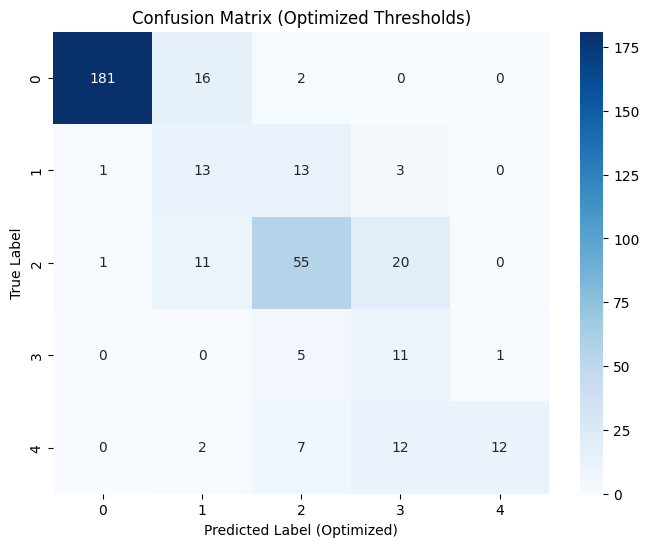

In [6]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize

# =============================================================================
# CONFIGURATION FOR 4-CHANNEL EFFICIENTNET-B3
# =============================================================================
class CFG:
    # --- MODEL CONFIG ---
    MODEL_NAME = 'efficientnet_b3'
    IMG_SIZE = 384
    
    # --- PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # --- PATHS TO YOUR SEGMENTED MASKS ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_VAL_DIR   = os.path.join(SEG_BASE_PATH, "segmented_outputs_val/segmented_outputs_val/")
    SEG_TEST_DIR  = os.path.join(SEG_BASE_PATH, "segmented_outputs_test/segmented_outputs_test/") # Assuming this is your test mask path
    
    # Path to your saved 4-channel model
    MODEL_PATH = "best_model_effnet_b3_seg_final.pth"
    
    # --- INFERENCE CONFIG ---
    BATCH_SIZE = 8 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING
# =============================================================================
class EfficientNet4ChannelOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        original_conv = self.backbone.conv_stem; original_weights = original_conv.weight.clone()
        new_conv = nn.Conv2d(4, original_conv.out_channels, 
                             kernel_size=original_conv.kernel_size, stride=original_conv.stride, 
                             padding=original_conv.padding, bias=(original_conv.bias is not None))
        with torch.no_grad():
            new_conv.weight[:, :3] = original_weights
            new_conv.weight[:, 3] = original_weights.mean(dim=1)
        self.backbone.conv_stem = new_conv
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))
    def forward(self, x): return self.classifier(self.backbone(x))

def preprocess_ben_graham(image, output_size):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
        else:
            _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea); x, y, w, h = cv2.boundingRect(largest_contour)
                image = image[y:y+h, x:x+w]
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    except Exception: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class Dataset4Channel(Dataset):
    def __init__(self, df, img_dir, seg_dir, transform=None):
        self.df, self.img_dir, self.seg_dir, self.transform = df.reset_index(drop=True), img_dir, seg_dir, transform
        self.post_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]), ToTensorV2()])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; img_path = os.path.join(self.img_dir, row['id_code'] + '.png'); seg_path = os.path.join(self.seg_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        img = preprocess_ben_graham(img, CFG.IMG_SIZE)
        mask = cv2.resize(mask, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            augmented = self.transform(image=img, mask=mask); img = augmented['image']; mask = augmented['mask']
        img_4_channel = np.dstack((img, mask))
        img_4_channel = self.post_transform(image=img_4_channel)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img_4_channel, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach(); targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5]); bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = EfficientNet4ChannelOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = Dataset4Channel(val_df, CFG.VAL_DIR, CFG.SEG_VAL_DIR, transform=None) # No augs for val
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE); outputs = model(images)
            val_outputs_list.append(outputs.cpu()); val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list); val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = Dataset4Channel(test_df, CFG.TEST_DIR, CFG.SEG_TEST_DIR, transform=None) # No augs for test
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE); outputs = model(images)
            test_outputs_list.append(outputs.cpu()); test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list); test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("      FINAL RESULTS COMPARISON (EffNet-B3 + Segmentation)")
    print("="*50)

    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):"); print(f"  QWK: {qwk_old:.4f}"); print(f"  Accuracy: {acc_old*100:.2f}%")

    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):"); print(f"  QWK: {qwk_new:.4f}"); print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    print("\n--- Polished Classification Report ---"); print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)"); plt.ylabel("True Label"); plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()


# Efficent net B4

In [5]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight

import timm

# =============================================================================
# CONFIGURATION FOR 4-CHANNEL EFFICIENTNET-B4
# =============================================================================
class CFG:
    # --- MODEL & IMAGE SIZE ---
    MODEL_NAME = 'efficientnet_b4'
    IMG_SIZE = 384
    BATCH_SIZE = 8

    # --- DATA PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    TRAIN_CSV = os.path.join(BASE_PATH, "train_1.csv")
    VAL_CSV   = os.path.join(BASE_PATH, "valid.csv")
    TRAIN_DIR = os.path.join(BASE_PATH, "train_images", "train_images")
    VAL_DIR   = os.path.join(BASE_PATH, "val_images", "val_images")
    
    # --- PATHS TO YOUR NEW SEGMENTED MASKS ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_TRAIN_DIR = os.path.join(SEG_BASE_PATH, "segmented_outputs_train_1/segmented_outputs_train_1/")
    SEG_VAL_DIR   = os.path.join(SEG_BASE_PATH, "segmented_outputs_val/segmented_outputs_val/")

    # --- TRAINING PIPELINE (Identical to your successful run for fair comparison) ---
    S1_EPOCHS = 15; S1_LR = 1e-4; S1_USE_MIXUP = True
    S2_EPOCHS = 15; S2_LR = 3e-5; S2_USE_MIXUP = False
    
    # --- GENERAL & SAVING ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2
    PATIENCE = 5
    SEED = 42
    LABEL_SMOOTHING = 0.05
    # New save paths for this experiment
    SAVE_PATH_S1 = "best_model_effnet_b4_seg_stage1.pth"
    SAVE_PATH_FINAL = "best_model_effnet_b4_seg_final.pth"

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = True
seed_everything(CFG.SEED)

# =============================================================================
# PREPROCESSING & AUGMENTATIONS (CORRECTED LOGIC)
# =============================================================================
def preprocess_ben_graham(image, output_size):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
        else:
            _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea); x, y, w, h = cv2.boundingRect(largest_contour)
                image = image[y:y+h, x:x+w]
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    except Exception: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

def get_transforms(is_train=True):
    if is_train:
        return A.Compose([
            A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        ])
    else:
        return None

# =============================================================================
# UPGRADED DATASET TO LOAD 4 CHANNELS
# =============================================================================
class Dataset4Channel(Dataset):
    def __init__(self, df, img_dir, seg_dir, transform=None):
        self.df, self.img_dir, self.seg_dir, self.transform = df.reset_index(drop=True), img_dir, seg_dir, transform
        self.post_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]),
            ToTensorV2()
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id_code'] + '.png')
        seg_path = os.path.join(self.seg_dir, row['id_code'] + '.png')
        
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        
        img = preprocess_ben_graham(img, CFG.IMG_SIZE)
        mask = cv2.resize(mask, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']
            
        img_4_channel = np.dstack((img, mask))
        img_4_channel = self.post_transform(image=img_4_channel)['image']
            
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img_4_channel, label

# =============================================================================
# UPGRADED MODEL TO ACCEPT 4 CHANNELS
# =============================================================================
class EfficientNet4ChannelOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        
        original_conv = self.backbone.conv_stem; original_weights = original_conv.weight.clone()
        new_conv = nn.Conv2d(4, original_conv.out_channels, 
                             kernel_size=original_conv.kernel_size, stride=original_conv.stride, 
                             padding=original_conv.padding, bias=(original_conv.bias is not None))
        with torch.no_grad():
            new_conv.weight[:, :3] = original_weights
            new_conv.weight[:, 3] = original_weights.mean(dim=1)
        self.backbone.conv_stem = new_conv
        
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))

    def forward(self, x): return self.classifier(self.backbone(x))

# --- Loss functions, training loops, and other utilities are unchanged ---
class WeightedOrdinalFocalLoss(nn.Module):
    def __init__(self, num_classes=5, gamma=2.0, class_weights=None, label_smoothing=0.0):
        super().__init__(); self.num_classes, self.gamma, self.class_weights, self.label_smoothing = num_classes, gamma, class_weights, label_smoothing; self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, outputs, targets):
        ordinal_targets = torch.zeros_like(outputs)
        for i, t in enumerate(targets):
            if t > 0: ordinal_targets[i, :t] = 1.0
        if self.label_smoothing > 0.0: ordinal_targets = ordinal_targets * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        bce = self.bce(outputs, ordinal_targets)
        if self.class_weights is not None:
            weights = self.class_weights[targets].view(-1, 1).expand(-1, outputs.shape[1]); bce = bce * weights
        pt = torch.exp(-bce); focal = (1 - pt) ** self.gamma * bce
        return focal.mean()

class SmoothKappaLoss(nn.Module):
    def __init__(self, num_classes=5, eps=1e-7):
        super().__init__(); self.num_classes, self.eps = num_classes, eps; W = torch.zeros(num_classes, num_classes)
        for i in range(num_classes):
            for j in range(num_classes): W[i,j] = ((i - j)**2) / ((num_classes - 1)**2)
        self.register_buffer("W", W)
    def forward(self, outputs, targets):
        device = outputs.device; B = outputs.size(0); probs = torch.sigmoid(outputs); class_probs = torch.zeros(B, self.num_classes, device=device)
        class_probs[:, 0] = 1 - probs[:, 0]
        for k in range(1, self.num_classes-1): class_probs[:, k] = probs[:, k-1] - probs[:, k]
        class_probs[:, -1] = probs[:, -1]
        class_probs = torch.clamp(class_probs, min=self.eps, max=1.0); one_hot = F.one_hot(targets, num_classes=self.num_classes).float().to(device); conf_mat = torch.matmul(one_hot.T, class_probs)
        hist_true = one_hot.sum(dim=0); hist_pred = class_probs.sum(dim=0); expected = torch.outer(hist_true, hist_pred)
        W = self.W.to(device); obs = torch.sum(W * conf_mat); exp = torch.sum(W * expected); kappa = 1.0 - (B * obs) / (exp + self.eps)
        return 1.0 - kappa

def mixup_data(x, y, alpha=0.4):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]; index = torch.randperm(batch_size).to(x.device); mixed_x = lam * x + (1 - lam) * x[index, :]; y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def ordinal_to_class(outputs): return torch.sum(torch.sigmoid(outputs) > 0.5, dim=1).long()
def calculate_metrics(outputs, targets):
    preds = ordinal_to_class(outputs).cpu().numpy(); targets_np = targets.cpu().numpy()
    return accuracy_score(targets_np, preds), cohen_kappa_score(targets_np, preds, weights='quadratic')
def clear_memory(): gc.collect(); torch.cuda.empty_cache()

def train_epoch(model, loader, optimizer, criterion, scaler, device, use_mixup):
    model.train(); running_loss = 0.0; all_out, all_t = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, targets in pbar:
        images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        if use_mixup: images, targets_a, targets_b, lam = mixup_data(images, targets)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            if use_mixup: loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            else: loss = criterion(outputs, targets)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        running_loss += loss.item(); all_out.append(outputs.detach()); all_t.append(targets.detach()); pbar.set_postfix(loss=loss.item())
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def validate_epoch(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; all_out, all_t = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, targets in pbar:
            images, targets = images.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)
            running_loss += loss.item(); all_out.append(outputs); all_t.append(targets)
    all_out, all_t = torch.cat(all_out), torch.cat(all_t)
    return running_loss / len(loader), *calculate_metrics(all_out, all_t)

def main():
    print(f"Device: {CFG.DEVICE}, Model: {CFG.MODEL_NAME} (4-Channel), Image Size: {CFG.IMG_SIZE}")
    train_df = pd.read_csv(CFG.TRAIN_CSV); val_df = pd.read_csv(CFG.VAL_CSV)
    
    train_tf = get_transforms(is_train=True)
    val_tf = get_transforms(is_train=False)

    train_ds = Dataset4Channel(train_df, CFG.TRAIN_DIR, CFG.SEG_TRAIN_DIR, transform=train_tf)
    val_ds   = Dataset4Channel(val_df, CFG.VAL_DIR, CFG.SEG_VAL_DIR, transform=val_tf)

    class_weights_sampler = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
    sample_weights = np.array([class_weights_sampler[int(l)] for l in train_df['diagnosis']])
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CFG.BATCH_SIZE*2, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    
    model = EfficientNet4ChannelOrdinal(CFG.MODEL_NAME).to(CFG.DEVICE)
    class_weights_loss = torch.tensor(class_weights_sampler, dtype=torch.float).to(CFG.DEVICE)
    focal_loss = WeightedOrdinalFocalLoss(num_classes=5, gamma=2.0, class_weights=class_weights_loss, label_smoothing=CFG.LABEL_SMOOTHING)
    kappa_loss = SmoothKappaLoss(num_classes=5)
    
    def hybrid_loss(outputs, targets): return 0.7 * kappa_loss(outputs, targets) + 0.3 * focal_loss(outputs, targets)
    
    scaler = torch.cuda.amp.GradScaler()

    # --- STAGE 1 ---
    print("\n" + "="*50 + "\n     STARTING STAGE 1 (4-Channel)\n" + "="*50)
    opt = optim.AdamW(model.parameters(), lr=CFG.S1_LR, weight_decay=1e-4)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S1_EPOCHS)
    best_val_qwk, patience_counter = -1, 0

    for epoch in range(CFG.S1_EPOCHS):
        clear_memory(); print(f"\nEpoch {epoch+1}/{CFG.S1_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, focal_loss, scaler, CFG.DEVICE, CFG.S1_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, focal_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss:{train_loss:.4f} Acc:{train_acc:.4f} QWK:{train_qwk:.4f}")
        print(f"Valid -> Loss:{val_loss:.4f} Acc:{val_acc:.4f} QWK:{val_qwk:.4f}")
        if val_qwk > best_val_qwk:
            print(f"Val QWK improved from {best_val_qwk:.4f} to {val_qwk:.4f}. Saving model...")
            best_val_qwk, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_S1)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 1."); break
    
    # --- STAGE 2 ---
    print("\n" + "="*50 + "\n     STARTING STAGE 2 (4-Channel)\n" + "="*50)
    if os.path.exists(CFG.SAVE_PATH_S1):
        model.load_state_dict(torch.load(CFG.SAVE_PATH_S1))
    else:
        print("No Stage 1 model was saved. Continuing with the current model.")

    opt = optim.AdamW(model.parameters(), lr=CFG.S2_LR, weight_decay=1e-5)
    sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=CFG.S2_EPOCHS)
    best_val_qwk_stage2, patience_counter = best_val_qwk, 0

    for epoch in range(CFG.S2_EPOCHS):
        clear_memory(); print(f"\nEpoch {epoch+1}/{CFG.S2_EPOCHS}")
        train_loss, train_acc, train_qwk = train_epoch(model, train_loader, opt, hybrid_loss, scaler, CFG.DEVICE, CFG.S2_USE_MIXUP)
        val_loss, val_acc, val_qwk = validate_epoch(model, val_loader, hybrid_loss, CFG.DEVICE)
        sched.step()
        print(f"Train -> Loss:{train_loss:.4f} Acc:{train_acc:.4f} QWK:{train_qwk:.4f}")
        print(f"Valid -> Loss:{val_loss:.4f} Acc:{val_acc:.4f} QWK:{val_qwk:.4f}")
        if val_qwk > best_val_qwk_stage2:
            print(f"Val QWK improved from {best_val_qwk_stage2:.4f} to {val_qwk:.4f}. Saving final model...")
            best_val_qwk_stage2, patience_counter = val_qwk, 0
            torch.save(model.state_dict(), CFG.SAVE_PATH_FINAL)
        else:
            patience_counter += 1
            if patience_counter >= CFG.PATIENCE: print("Early stopping in Stage 2."); break

    print(f"\nTraining Finished!\nFinal Best QWK: {best_val_qwk_stage2:.4f}")

if __name__ == "__main__":
    main()

Device: cuda, Model: efficientnet_b4 (4-Channel), Image Size: 384


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



     STARTING STAGE 1 (4-Channel)

Epoch 1/15


/tmp/ipykernel_36/1754439637.py:240: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.4959 Acc:0.2328 QWK:0.0820
Valid -> Loss:0.1856 Acc:0.1475 QWK:0.5833
Val QWK improved from -1.0000 to 0.5833. Saving model...

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.4075 Acc:0.2863 QWK:0.3137
Valid -> Loss:0.1676 Acc:0.1749 QWK:0.6742
Val QWK improved from 0.5833 to 0.6742. Saving model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.3713 Acc:0.3113 QWK:0.3511
Valid -> Loss:0.1607 Acc:0.1694 QWK:0.6776
Val QWK improved from 0.6742 to 0.6776. Saving model...

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.3383 Acc:0.3287 QWK:0.3657
Valid -> Loss:0.1597 Acc:0.1667 QWK:0.6170

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.3140 Acc:0.3608 QWK:0.3903
Valid -> Loss:0.1560 Acc:0.1967 QWK:0.6389

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.3030 Acc:0.3549 QWK:0.3902
Valid -> Loss:0.1482 Acc:0.1995 QWK:0.6385

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2838 Acc:0.3587 QWK:0.3824
Valid -> Loss:0.1661 Acc:0.1913 QWK:0.6046

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2663 Acc:0.3758 QWK:0.4305
Valid -> Loss:0.1566 Acc:0.1885 QWK:0.6528
Early stopping in Stage 1.

     STARTING STAGE 2 (4-Channel)

Epoch 1/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.3819 Acc:0.4577 QWK:0.7624
Valid -> Loss:0.3297 Acc:0.2104 QWK:0.6657

Epoch 2/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.3123 Acc:0.5294 QWK:0.8039
Valid -> Loss:0.2566 Acc:0.6284 QWK:0.8472
Val QWK improved from 0.6776 to 0.8472. Saving final model...

Epoch 3/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2739 Acc:0.5901 QWK:0.8486
Valid -> Loss:0.2313 Acc:0.6230 QWK:0.8558
Val QWK improved from 0.8472 to 0.8558. Saving final model...

Epoch 4/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2619 Acc:0.6198 QWK:0.8550
Valid -> Loss:0.2178 Acc:0.6694 QWK:0.8656
Val QWK improved from 0.8558 to 0.8656. Saving final model...

Epoch 5/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2553 Acc:0.6283 QWK:0.8625
Valid -> Loss:0.2136 Acc:0.6749 QWK:0.8746
Val QWK improved from 0.8656 to 0.8746. Saving final model...

Epoch 6/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2539 Acc:0.6413 QWK:0.8662
Valid -> Loss:0.2173 Acc:0.6721 QWK:0.8659

Epoch 7/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2372 Acc:0.6403 QWK:0.8710
Valid -> Loss:0.2124 Acc:0.6530 QWK:0.8655

Epoch 8/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2310 Acc:0.6601 QWK:0.8814
Valid -> Loss:0.2065 Acc:0.6667 QWK:0.8682

Epoch 9/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2277 Acc:0.6631 QWK:0.8845
Valid -> Loss:0.2143 Acc:0.6667 QWK:0.8664

Epoch 10/15


Training:   0%|          | 0/367 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:197: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validating:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_36/1754439637.py:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): outputs = model(images); loss = criterion(outputs, targets)


Train -> Loss:0.2164 Acc:0.6662 QWK:0.8857
Valid -> Loss:0.2179 Acc:0.6749 QWK:0.8654
Early stopping in Stage 2.

Training Finished!
Final Best QWK: 0.8746


Model loaded successfully from /kaggle/input/models-to-test/best_model_effnet_b4_seg_final.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


Getting Validation Outputs:   0%|          | 0/46 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.4406 0.2155 0.5599 0.6859]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e14c244180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79e14c244180>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


      FINAL RESULTS COMPARISON (EffNet-B4 + Segmentation)

Original Score (Threshold = 0.5):
  QWK: 0.8713
  Accuracy: 70.49%

Polished Score (Optimized Thresholds):
  QWK: 0.8798
  Accuracy: 70.22%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.99      0.92      0.95       199
     Class 1       0.35      0.60      0.44        30
     Class 2       0.67      0.39      0.49        87
     Class 3       0.20      0.82      0.32        17
     Class 4       1.00      0.24      0.39        33

    accuracy                           0.70       366
   macro avg       0.64      0.60      0.52       366
weighted avg       0.82      0.70      0.72       366


--- Polished Confusion Matrix ---


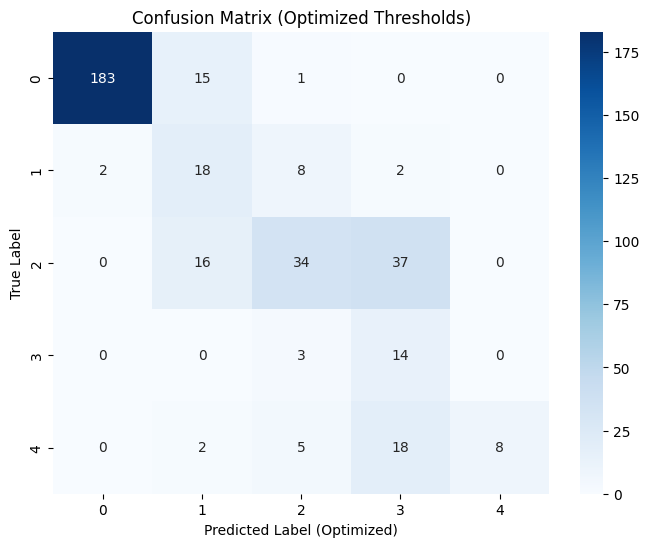

In [6]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize

# =============================================================================
# CONFIGURATION FOR 4-CHANNEL EFFICIENTNET-B4
# =============================================================================
class CFG:
    # --- MODEL CONFIG ---
    MODEL_NAME = 'efficientnet_b4'
    IMG_SIZE = 384
    
    # --- PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # --- PATHS TO YOUR SEGMENTED MASKS ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_VAL_DIR   = os.path.join(SEG_BASE_PATH, "segmented_outputs_val/segmented_outputs_val/")
    SEG_TEST_DIR  = os.path.join(SEG_BASE_PATH, "segmented_outputs_test/segmented_outputs_test/")
    
    # Path to your saved 4-channel model
    MODEL_PATH = "/kaggle/input/models-to-test/best_model_effnet_b4_seg_final.pth"
    
    # --- INFERENCE CONFIG ---
    BATCH_SIZE = 8 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING
# =============================================================================
class EfficientNet4ChannelOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool='avg')
        
        original_conv = self.backbone.conv_stem
        original_weights = original_conv.weight.clone()

        new_conv = nn.Conv2d(4, original_conv.out_channels, 
                             kernel_size=original_conv.kernel_size, stride=original_conv.stride, 
                             padding=original_conv.padding, bias=(original_conv.bias is not None))
        
        with torch.no_grad():
            new_conv.weight[:, :3] = original_weights
            new_conv.weight[:, 3] = original_weights.mean(dim=1)
        
        self.backbone.conv_stem = new_conv
        
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))

    def forward(self, x): 
        return self.classifier(self.backbone(x))


def preprocess_ben_graham(image, output_size):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
        else:
            _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea); x, y, w, h = cv2.boundingRect(largest_contour)
                image = image[y:y+h, x:x+w]
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    except Exception: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class Dataset4Channel(Dataset):
    def __init__(self, df, img_dir, seg_dir, transform=None):
        self.df, self.img_dir, self.seg_dir, self.transform = df.reset_index(drop=True), img_dir, seg_dir, transform
        self.post_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]),
            ToTensorV2()
        ])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; img_path = os.path.join(self.img_dir, row['id_code'] + '.png'); seg_path = os.path.join(self.seg_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        img = preprocess_ben_graham(img, CFG.IMG_SIZE)
        mask = cv2.resize(mask, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            augmented = self.transform(image=img, mask=mask); img = augmented['image']; mask = augmented['mask']
        img_4_channel = np.dstack((img, mask))
        img_4_channel = self.post_transform(image=img_4_channel)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img_4_channel, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach(); targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5]); bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = EfficientNet4ChannelOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = Dataset4Channel(val_df, CFG.VAL_DIR, CFG.SEG_VAL_DIR, transform=None) # No augs for val
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE); outputs = model(images)
            val_outputs_list.append(outputs.cpu()); val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list); val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = Dataset4Channel(test_df, CFG.TEST_DIR, CFG.SEG_TEST_DIR, transform=None) # No augs for test
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE); outputs = model(images)
            test_outputs_list.append(outputs.cpu()); test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list); test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("      FINAL RESULTS COMPARISON (EffNet-B4 + Segmentation)")
    print("="*50)

    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):"); print(f"  QWK: {qwk_old:.4f}"); print(f"  Accuracy: {acc_old*100:.2f}%")

    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):"); print(f"  QWK: {qwk_new:.4f}"); print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    print("\n--- Polished Classification Report ---"); print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)"); plt.ylabel("True Label"); plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()


# SWIN TEST

Model loaded successfully from /kaggle/input/models-to-test/best_model_swin_seg_final.pth

--- Step 1: Evaluating on Validation Set to find thresholds ---


Getting Validation Outputs:   0%|          | 0/23 [00:00<?, ?it/s]


--- Step 2: Optimizing Thresholds ---
Finding optimal thresholds...
Optimal thresholds found: [0.5799 0.283  0.883  0.4561]

--- Step 3: Evaluating on Test Set with new thresholds ---


Getting Test Outputs:   0%|          | 0/23 [00:00<?, ?it/s]


      FINAL RESULTS COMPARISON (Swin + Segmentation)

Original Score (Threshold = 0.5):
  QWK: 0.8845
  Accuracy: 72.13%

Polished Score (Optimized Thresholds):
  QWK: 0.8935
  Accuracy: 74.59%

--- Polished Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.98      0.94      0.96       199
     Class 1       0.36      0.57      0.44        30
     Class 2       0.68      0.54      0.60        87
     Class 3       0.18      0.47      0.26        17
     Class 4       0.87      0.39      0.54        33

    accuracy                           0.75       366
   macro avg       0.62      0.58      0.56       366
weighted avg       0.81      0.75      0.76       366


--- Polished Confusion Matrix ---


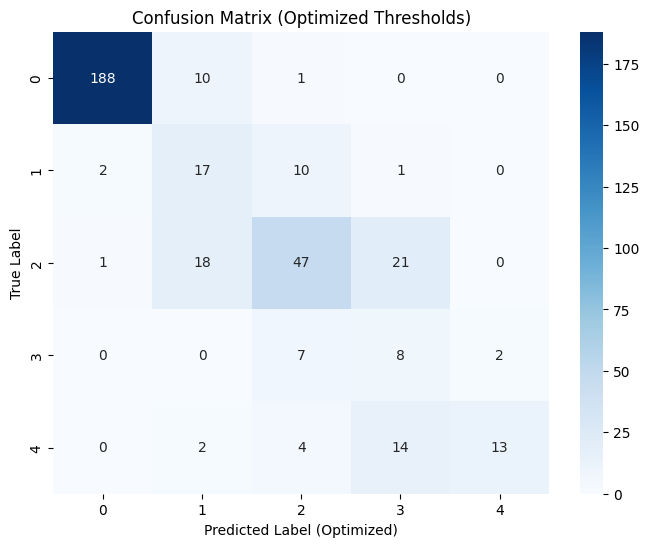

In [4]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import timm
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize

# =============================================================================
# CONFIGURATION FOR 4-CHANNEL SWIN TRANSFORMER
# =============================================================================
class CFG:
    # --- MODEL CONFIG ---
    MODEL_NAME = 'swinv2_tiny_window8_256'
    IMG_SIZE = 256
    
    # --- PATHS ---
    BASE_PATH = "/kaggle/input/aptos2019"
    VAL_CSV = os.path.join(BASE_PATH, "valid.csv")
    VAL_DIR = os.path.join(BASE_PATH, "val_images", "val_images")
    TEST_CSV = os.path.join(BASE_PATH, "test.csv")
    TEST_DIR = os.path.join(BASE_PATH, "test_images", "test_images")
    
    # --- PATHS TO YOUR SEGMENTED MASKS ---
    SEG_BASE_PATH = "/kaggle/input/segmentaion-dataset/"
    SEG_VAL_DIR   = os.path.join(SEG_BASE_PATH, "segmented_outputs_val/segmented_outputs_val/")
    SEG_TEST_DIR  = os.path.join(SEG_BASE_PATH, "segmented_outputs_test/segmented_outputs_test/")
    
    # Path to your saved 4-channel model
    MODEL_PATH = "/kaggle/input/models-to-test/best_model_swin_seg_final.pth"
    
    # --- INFERENCE CONFIG ---
    BATCH_SIZE = 16 
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NUM_WORKERS = 2

# =============================================================================
# REUSED CLASSES & PREPROCESSING
# =============================================================================
class Swin4ChannelOrdinal(nn.Module):
    def __init__(self, model_name, num_classes=5, pretrained=False):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool='avg')
        
        original_proj = self.backbone.patch_embed.proj
        original_weights = original_proj.weight.clone()

        new_proj = nn.Conv2d(4, original_proj.out_channels, 
                             kernel_size=original_proj.kernel_size, stride=original_proj.stride, 
                             padding=original_proj.padding, bias=(original_proj.bias is not None))
        
        with torch.no_grad():
            new_proj.weight[:, :3] = original_weights
            new_proj.weight[:, 3] = original_weights.mean(dim=1)
        
        self.backbone.patch_embed.proj = new_proj
        
        feature_dim = self.backbone.num_features
        self.classifier = nn.Sequential(nn.Linear(feature_dim, 256), nn.ReLU(), nn.Dropout(0.3), nn.Linear(256, num_classes - 1))

    def forward(self, x): 
        return self.classifier(self.backbone(x))

def preprocess_ben_graham(image, output_size):
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if gray.mean() < 15: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
        else:
            _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea); x, y, w, h = cv2.boundingRect(largest_contour)
                image = image[y:y+h, x:x+w]
            image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    except Exception: image = cv2.resize(image, (output_size, output_size), interpolation=cv2.INTER_AREA)
    b, g, r = cv2.split(image); clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)); g = clahe.apply(g)
    return cv2.merge((b, g, r))

class Dataset4Channel(Dataset):
    def __init__(self, df, img_dir, seg_dir, transform=None):
        self.df, self.img_dir, self.seg_dir, self.transform = df.reset_index(drop=True), img_dir, seg_dir, transform
        self.post_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5]),
            ToTensorV2()
        ])
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; img_path = os.path.join(self.img_dir, row['id_code'] + '.png'); seg_path = os.path.join(self.seg_dir, row['id_code'] + '.png')
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)
        img = preprocess_ben_graham(img, CFG.IMG_SIZE)
        mask = cv2.resize(mask, (CFG.IMG_SIZE, CFG.IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            augmented = self.transform(image=img, mask=mask); img = augmented['image']; mask = augmented['mask']
        img_4_channel = np.dstack((img, mask))
        img_4_channel = self.post_transform(image=img_4_channel)['image']
        label = torch.tensor(row['diagnosis'], dtype=torch.long)
        return img_4_channel, label

# =============================================================================
# OPTIMIZATION FUNCTIONS
# =============================================================================
def ordinal_to_class_with_thresholds(outputs, thresholds):
    probs = torch.sigmoid(outputs).cpu().numpy()
    preds = np.sum(probs > thresholds, axis=1)
    return preds

def kappa_objective(thresholds, outputs, targets):
    preds = ordinal_to_class_with_thresholds(outputs, thresholds)
    return -cohen_kappa_score(targets, preds, weights="quadratic")

def find_best_thresholds(outputs, targets):
    print("Finding optimal thresholds...")
    outputs = outputs.detach(); targets = targets.cpu().numpy()
    init_thresh = np.array([0.5, 0.5, 0.5, 0.5]); bounds = [(0.1, 0.9)] * len(init_thresh)
    res = minimize(kappa_objective, init_thresh, args=(outputs, targets), method="Powell", bounds=bounds)
    best_thresholds = res.x
    print(f"Optimal thresholds found: {np.round(best_thresholds, 4)}")
    return best_thresholds

# =============================================================================
# MAIN SCRIPT
# =============================================================================
def run_optimization_and_test():
    # --- Step 0: Load Model ---
    model = Swin4ChannelOrdinal(CFG.MODEL_NAME, pretrained=False).to(CFG.DEVICE)
    model.load_state_dict(torch.load(CFG.MODEL_PATH, map_location=CFG.DEVICE))
    model.eval()
    print(f"Model loaded successfully from {CFG.MODEL_PATH}")

    # --- Step 1: Get Raw Answers on the Validation Set ---
    print("\n--- Step 1: Evaluating on Validation Set to find thresholds ---")
    val_df = pd.read_csv(CFG.VAL_CSV)
    val_dataset = Dataset4Channel(val_df, CFG.VAL_DIR, CFG.SEG_VAL_DIR, transform=None)
    val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
    
    val_outputs_list, val_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Getting Validation Outputs"):
            images = images.to(CFG.DEVICE); outputs = model(images)
            val_outputs_list.append(outputs.cpu()); val_labels_list.append(labels)
    val_outputs = torch.cat(val_outputs_list); val_labels = torch.cat(val_labels_list)
    
    # --- Step 2: Find the Perfect "Grading Scale" ---
    print("\n--- Step 2: Optimizing Thresholds ---")
    best_thresholds = find_best_thresholds(val_outputs, val_labels)

    # --- Step 3: Use the Grading Scale on the Test Set ---
    print("\n--- Step 3: Evaluating on Test Set with new thresholds ---")
    test_df = pd.read_csv(CFG.TEST_CSV)
    test_dataset = Dataset4Channel(test_df, CFG.TEST_DIR, CFG.SEG_TEST_DIR, transform=None)
    test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

    test_outputs_list, test_labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Getting Test Outputs"):
            images = images.to(CFG.DEVICE); outputs = model(images)
            test_outputs_list.append(outputs.cpu()); test_labels_list.append(labels)
    test_outputs = torch.cat(test_outputs_list); test_labels = torch.cat(test_labels_list).numpy()
    
    # --- FINAL RESULTS ---
    print("\n" + "="*50)
    print("      FINAL RESULTS COMPARISON (Swin + Segmentation)")
    print("="*50)

    preds_old = torch.sum(torch.sigmoid(test_outputs) > 0.5, dim=1).numpy()
    qwk_old = cohen_kappa_score(test_labels, preds_old, weights='quadratic')
    acc_old = accuracy_score(test_labels, preds_old)
    print(f"\nOriginal Score (Threshold = 0.5):"); print(f"  QWK: {qwk_old:.4f}"); print(f"  Accuracy: {acc_old*100:.2f}%")

    preds_new = ordinal_to_class_with_thresholds(test_outputs, best_thresholds)
    qwk_new = cohen_kappa_score(test_labels, preds_new, weights='quadratic')
    acc_new = accuracy_score(test_labels, preds_new)
    print(f"\nPolished Score (Optimized Thresholds):"); print(f"  QWK: {qwk_new:.4f}"); print(f"  Accuracy: {acc_new*100:.2f}%")
    print("="*50)
    
    print("\n--- Polished Classification Report ---"); print(classification_report(test_labels, preds_new, target_names=[f"Class {i}" for i in range(5)]))
    
    print("\n--- Polished Confusion Matrix ---")
    cm = confusion_matrix(test_labels, preds_new)
    plt.figure(figsize=(8, 6)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
    plt.xlabel("Predicted Label (Optimized)"); plt.ylabel("True Label"); plt.title("Confusion Matrix (Optimized Thresholds)")
    plt.show()
    
run_optimization_and_test()

------------------------------------------